In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import timm
from torchmetrics import Metric
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import random

In [2]:
class NMAE(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("nmae", default=torch.tensor(0.), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        nmae = torch.sum(torch.abs(target-preds) / (torch.abs(target)))
        n_obs = target.numel()
        self.nmae += nmae
        self.total += n_obs
    def compute(self):
        return self.nmae / self.total


In [3]:

preprocessing_train_imgs = glob("D:/DACON_GROWTH/PREPROCESSING-TRAIN_224/*")
preprocessing_test_imgs = glob("D:/DACON_GROWTH/PREPROCESSING-TEST_224/*")
augmetation_imgs = glob("D:/DACON_GROWTH/AUGMENTATION/SIZE224/*")

train_path = []
train_imgs = []
for path in tqdm(preprocessing_train_imgs):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    train_path.append(path)
    train_imgs.append(img)

test_path = []
test_imgs = []
for path in tqdm(preprocessing_test_imgs):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    test_path.append(path)
    test_imgs.append(img)

augment_path = []
augment_imgs = []
for path in tqdm(augmetation_imgs):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    augment_path.append(path)
    augment_imgs.append(img)


train_df = pd.read_parquet("D:/DACON_GROWTH/train.parquet")
test_df = pd.read_parquet("D:/DACON_GROWTH/test.parquet")

train_df["무게"] = train_df["무게"].apply(lambda x: 0.001 if x<0.001 else x)

img2weight = {}
for i in tqdm(train_df["이미지"].unique()):
    temp = train_df[train_df["이미지"]==i]
    weight = temp["무게"].values[0]
    img2weight[i] = weight

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1592/1592 [05:02<00:00,  5.26it/s]


In [4]:

train_df["시간2"] = train_df["시간"].apply(lambda x: x.split(" ")[-1])
golden_time = ['17:40', '17:41', '17:42', '17:43', '17:44', '17:45', '17:46', '17:47', '17:48', '17:49', '17:50',
               '17:51', '17:52', '17:53', '17:54', '17:55', '17:56', '17:57', '17:58', '17:59', '18:00', '18:01',
               '18:02', '18:03', '18:04', '18:05']
golden_dict ={}
for e, i in enumerate(train_df["시간2"].unique()):
       golden_dict[i] = e
train_df["순서"] = train_df["시간2"].apply(lambda x : golden_dict[x])
start = golden_dict['17:40']
end = golden_dict["18:05"]

train_golden_df = train_df[(train_df["순서"] > 894) & (train_df["순서"] < 919)]

features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

img2data = {}
for i in tqdm(train_golden_df["이미지"].unique()):
       temp = train_golden_df[train_golden_df["이미지"]==i]
       temp_mean = temp[features].mean(axis=0)
       img2data[temp["이미지"].values[0]] = temp_mean[["EC관측치",'내부습도관측치', '외부습도관측치']].values


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1592/1592 [00:08<00:00, 188.44it/s]


In [5]:
test_df["시간2"] = test_df["시간"].apply(lambda x: x.split(" ")[-1])
test_df["순서"] = test_df["시간2"].apply(lambda x : golden_dict[x])
test_golden_df = test_df[(test_df["순서"] > 894) & (test_df["순서"] < 919)]
img2test = {}
for i in tqdm(test_golden_df["이미지"].unique()):
       temp = test_golden_df[test_golden_df["이미지"]==i]
       temp_mean = temp[features].mean(axis=0)
       img2test[temp["이미지"].values[0]] = temp_mean[["EC관측치",'내부습도관측치', '외부습도관측치']].values


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:01<00:00, 332.42it/s]


In [6]:

class PYTORCH_DATASET(nn.Module):
    def __init__(self, path: list, img2weight: dict, imgs: np.array, img2data: dict,  \
                 transform=None):
        super(PYTORCH_DATASET, self).__init__()
        self.path = path
        self.imgs = imgs

        self.transform = transform
        self.img2weight = img2weight
        self.img2data = img2data

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        before_img = self.imgs[idx]
        img_path = self.path[idx]
        img_path = img_path.split("\\")[-1].split(".")[0]
        df_index = self.img2data[img_path]
        df_label = self.img2weight[img_path]

        after_img = self.transform(image=before_img)["image"]

        return {"사진": after_img, "정보": df_index, "상표": df_label}


class PYTORCH_PREDICTSET(nn.Module):
    def __init__(self, path: list,  imgs: np.array, img2data: dict, \
                 transform=None):
        super(PYTORCH_PREDICTSET, self).__init__()
        self.path = path
        self.imgs = imgs

        self.transform = transform
        self.img2data = img2data

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        before_img = self.imgs[idx]
        img_path = self.path[idx]
        img_path = img_path.split("\\")[-1].split(".")[0]
        df_index = self.img2data[img_path]
        after_img = self.transform(image=before_img)["image"]
        return {"사진": after_img, "정보": df_index}

class PYTORCH_AUGMENTSET(nn.Module):
    def __init__(self, aug_imgs: np.array, transform_ori = None, transform_aug=None):
        super(PYTORCH_AUGMENTSET, self).__init__()
        self.aug_imgs = aug_imgs
        self.transform_ori = transform_ori
        self.transform_aug = transform_aug

    def __len__(self):
        return len(self.aug_imgs)

    def __getitem__(self, idx):
        before_img = self.aug_imgs[idx]
        after_img = self.transform_aug(image=before_img)["image"]
        before_img = self.transform_ori(image=before_img)["image"]
        temp_data = torch.FloatTensor([[0, 0, 0]])

        return {"원본": before_img, "확장": after_img, "정보": temp_data}

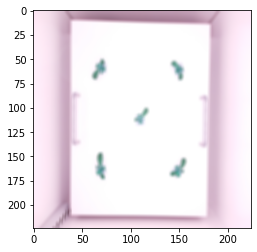

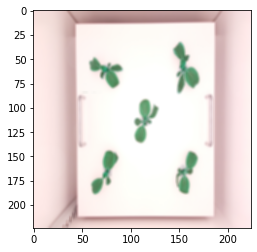

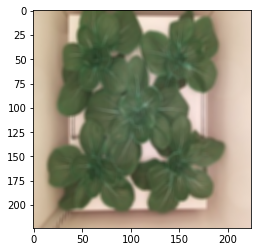

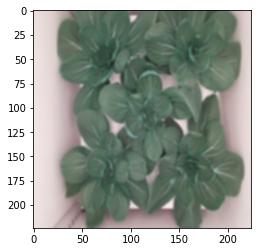

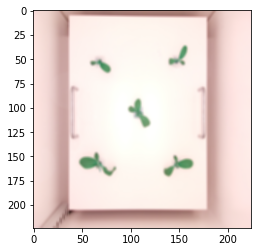

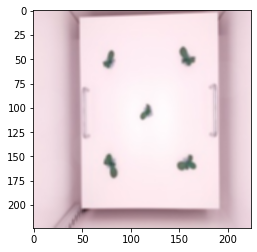

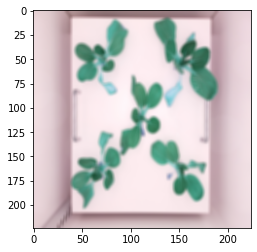

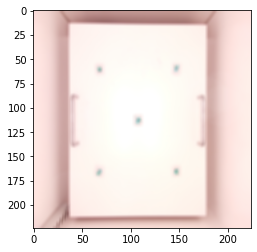

In [9]:
image_size = 224
import PIL
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
train_mode= albu.Compose([
    albu.RandomFog(fog_coef_lower=0.5, fog_coef_upper=0.6,p=1),
    #     albu.RandomResizedCrop(height=image_size, width=image_size,
#                            scale=(0.25, 1.0), ratio=(0.2, 2),
#                            interpolation=1, p=1),
#     albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
#                           rotate_limit=30, interpolation=1, border_mode=0, value=0, p=1),
#     albu.HorizontalFlip(p=0.5),
#     albu.VerticalFlip(p=0.5),
#     albu.OneOf([
#         albu.MotionBlur(p=.2),
#         albu.MedianBlur(blur_limit=3, p=0.1),
#         albu.Blur(blur_limit=3, p=0.1),
#     ], p=0.25),
#     albu.OneOf([
#         albu.CLAHE(clip_limit=2),
#         albu.Sharpen(),
#         albu.Emboss(),
#         albu.RandomBrightnessContrast(),
#     ], p=0.25),
#     albu.CoarseDropout(max_holes=32, max_height=8, max_width=8, fill_value=0, p=1),
#     albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ToTensorV2(),
])

temp_dataset = PYTORCH_DATASET(path=train_path, img2weight=img2weight, imgs=train_imgs, img2data=img2data,\
                                            transform=train_mode)
temp_loader = DataLoader(temp_dataset, shuffle=True, batch_size=8, num_workers=0)

for batch in temp_loader:
    imgs = batch["사진"]
    for img in imgs:
        tf = transforms.ToPILImage()
        img_t = tf(img)
        plt.imshow(img_t)
        plt.show()
    break

In [7]:

image_size = 224

train_mode= albu.Compose([
    albu.RandomResizedCrop(height=image_size, width=image_size,
                           scale=(0.25, 1.0), ratio=(0.75, 1.3333333333333333),
                           interpolation=1, p=0.9),
    albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                          rotate_limit=30, interpolation=1, border_mode=0, value=0, p=0.25),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([
        albu.MotionBlur(p=.2),
        albu.MedianBlur(blur_limit=3, p=0.1),
        albu.Blur(blur_limit=3, p=0.1),
    ], p=0.25),
    albu.OneOf([
        albu.CLAHE(clip_limit=2),
        albu.Sharpen(),
        albu.Emboss(),
        albu.RandomBrightnessContrast(),
    ], p=0.25),
    albu.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.25),
    albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ToTensorV2(),
])

test_mode = albu.Compose([
    #                 albu.Resize(self.image_size, self.image_size),
    albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ToTensorV2(),
])

class CNN_RNN(nn.Module):
    def __init__(self):
        super(CNN_RNN, self).__init__()
        self.model = timm.create_model("efficientnet_b0", pretrained=True, \
                                       num_classes=1)
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1283, 256)
        self.output = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.9)
        self.dropout1 = nn.Dropout(0.65)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0)

    def forward(self,  x, x2, training):
        x = self.model.forward_features(x)
        x = self.avg(x)
        x = x.flatten()
        x = x.view(-1,  1280)
        x = self.dropout(x)
        x2 = x2.view(-1, 3)
        if training:
            c = random.choice([0, 0, 0, 1, 2, 3])
            if c == 0:
                pass
            elif c == 1:
                x2 = self.dropout1(x2)
            elif c == 2:
                x2 = self.dropout2(x2)
            elif c == 3:
                x2 = self.dropout3(x2)
        x = torch.cat([x, x2], dim=-1)
        x = self.linear(x)
        x = self.relu(x)
        x = self.output(x)
        return x


In [10]:
from pytorch_lightning.trainer.supporters import CombinedLoader
from adabelief_pytorch import AdaBelief

class LIGHTNING_MODEL(pl.LightningModule):
    def __init__(self, train_datasest, val_dataset, augment_dataset, predict_dataset):
        super(LIGHTNING_MODEL, self).__init__()
        self.model = CNN_RNN()
        self.train_nmae = NMAE()
        self.valid_nmae = NMAE()
        self.augment_dataset= augment_dataset
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.predict_dataset = predict_dataset
        self.bestnmae = 10.
        
    def forward(self, x):
        output = self.model(x)
        return output
    
    def train_dataloader(self):
        loaders = {"a": DataLoader(self.train_dataset, shuffle=True, batch_size=32, num_workers=0), \
                   "b": DataLoader(self.augment_dataset, shuffle=True, batch_size=8, num_workers=0)}
        combined_loaders = CombinedLoader(loaders, mode="max_size_cycle")
        return combined_loaders
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, shuffle=False, batch_size=32, num_workers=0)
    
    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, shuffle=False, batch_size=32, num_workers=0)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        ori_batch = train_batch["a"]
        aug_batch = train_batch["b"]
        img = ori_batch["사진"]
        data = ori_batch["정보"]
        label = ori_batch["상표"]
        
        ori = aug_batch["원본"]
        ext = aug_batch["확장"]
        temp_data = aug_batch["정보"]

        pred = self.model(img, data, training=True)
        pred = pred.view(-1)
        label = label.view(-1)
        
        train_loss = nn.L1Loss()(pred, label)
        self.log("train_loss", train_loss)
        
        train_nmae = self.train_nmae(pred, label)
        self.log('train_NMAE', train_nmae)
        
        with torch.no_grad():
            ori_out = self.model(ori, temp_data, training=False)
            ext_out = self.model(ext, temp_data, training=False)
        con_loss = nn.L1Loss()(ori_out, ext_out)
        con_loss = 0.25 * con_loss 
        self.log('con_loss', con_loss)
        loss = train_loss + con_loss
        self.log('loss', loss)
        return train_loss

    def training_epoch_end(self, outputs):
        train_nmae = self.train_nmae.compute()
        self.log("epoch_train_nmae", train_nmae)
        self.train_nmae.reset()
        print(f"training nmae: {train_nmae:.4}")
        
        
    def validation_step(self, val_batch, batch_idx):
        img = val_batch["사진"]
        data = val_batch["정보"]
        label = val_batch["상표"]

        pred = self.model(img, data, training=False)
        pred = pred.view(-1)
        label = label.view(-1)
        loss = nn.L1Loss()(pred, label)
        self.log("val_loss", loss)
        self.valid_nmae.update(pred, label)
        return loss

    def validation_epoch_end(self, outputs):
        val_nmae = self.valid_nmae.compute()
        self.log("val_nmae", val_nmae)
        ext = val_nmae.item()
        if ext < self.bestnmae:
            self.bestnmae = ext
        self.valid_nmae.reset()
        print(f"validation nmae: {val_nmae:.4}")

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        img = batch["사진"]
        data = batch["정보"]
        pred = self.model(img, data, training=False).unsqueeze(0)
        return pred



In [1]:

kf = KFold(n_splits=15, shuffle=False)
if __name__ == '__main__':
    for fold, (ti, vi) in enumerate(kf.split(train_path)):
        if fold < 1:                                                                                                                   
            trainset_path, validset_path = np.array(train_path)[ti], np.array(train_path)[vi]
            train_imgset, valid_imgset = np.array(train_imgs)[ti], np.array(train_imgs)[vi]

            train_dataset = PYTORCH_DATASET(path=trainset_path, img2weight=img2weight, imgs=train_imgset, img2data=img2data,\
                                            transform=train_mode)

            valid_dataset = PYTORCH_DATASET(path=validset_path, img2weight=img2weight, imgs=valid_imgset, img2data=img2data,\
                                            transform=test_mode)

            augment_dataset = PYTORCH_AUGMENTSET(aug_imgs=augment_imgs, transform_ori=test_mode, transform_aug=train_mode)

            test_dataset = PYTORCH_PREDICTSET(path=validset_path, imgs=valid_imgset, img2data=img2data, \
                                    transform=test_mode)
            
            
            model_name = "efficientnetB0"
            
            model = LIGHTNING_MODEL(train_dataset, valid_dataset, augment_dataset, test_dataset)

            check_path =  f"D:/DACON_GROWTH/checkpoint{fold}/{model_name}"
            if not os.path.exists(check_path):
                os.makedirs(check_path)
            checkpoint_callback = ModelCheckpoint(dirpath=check_path, save_top_k=1, monitor="val_nmae", \
                                                  save_weights_only=True)

            early_stopping = EarlyStopping(
            monitor='val_nmae',
            patience=20,
            verbose=False,
            mode='min')
        
            trainer = pl.Trainer(
                devices=[0],
                accelerator='gpu',
                max_epochs=1,
                callbacks=[checkpoint_callback, early_stopping],
                precision=16
            )

            trainer.fit(model)

    #                 # trainer.save_checkpoint("example.ckpt")
            bestscore = model.bestnmae
            checkpoint_ = os.listdir(check_path)[0]
            file_name = os.path.basename(checkpoint_).split(".ckpt")[0]
            src = os.path.join(check_path, checkpoint_)
            score_name = file_name + f"_{bestscore : .4f}.ckpt"
            dst = os.path.join(check_path, score_name)
            os.rename(src, dst)
            os.remove(src)

NameError: name 'KFold' is not defined

In [79]:
#Prediction_time

test_dataset = PYTORCH_PREDICTSET(path=test_path, imgs=test_imgs, img2data=img2test, \
                                    transform=test_mode)

model = LIGHTNING_MODEL.load_from_checkpoint(checkpoint_path="D:/DACON_GROWTH/checkpoint0/epoch=46-step=2914.ckpt",
                          train_datasest = None, val_dataset = None, \
                augment_dataset= None, predict_dataset = test_dataset)



In [80]:
trainer = pl.Trainer(
                devices=[0],
                accelerator='gpu',
                max_epochs=100,
                # log_every_n_steps=32,
                callbacks=[checkpoint_callback],
                precision=16
            )

prediction = trainer.predict(model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [87]:
sub_list = []
for p in prediction:
    p = p.view(-1)
    for sample in p:
        sample = sample.cpu().numpy()
        sub_list.append(sample)

In [89]:
sub_list

[array(61.53, dtype=float16),
 array(299., dtype=float16),
 array(4.473, dtype=float16),
 array(72.44, dtype=float16),
 array(82.44, dtype=float16),
 array(79.75, dtype=float16),
 array(1.075, dtype=float16),
 array(76.6, dtype=float16),
 array(1.221, dtype=float16),
 array(76.3, dtype=float16),
 array(0.5015, dtype=float16),
 array(33.2, dtype=float16),
 array(10.71, dtype=float16),
 array(31.86, dtype=float16),
 array(17.44, dtype=float16),
 array(77.5, dtype=float16),
 array(72.8, dtype=float16),
 array(33.06, dtype=float16),
 array(83.6, dtype=float16),
 array(292.5, dtype=float16),
 array(40.5, dtype=float16),
 array(5.98, dtype=float16),
 array(2.076, dtype=float16),
 array(17.33, dtype=float16),
 array(72.9, dtype=float16),
 array(75.4, dtype=float16),
 array(126.5, dtype=float16),
 array(43.53, dtype=float16),
 array(78.9, dtype=float16),
 array(85.9, dtype=float16),
 array(76.1, dtype=float16),
 array(20.47, dtype=float16),
 array(1.618, dtype=float16),
 array(5.457, dtype=flo

In [110]:
sample_submission = pd.read_csv("D:/DACON_GROWTH/sample_submission.csv")
sample_submission

,img_name,leaf_weight
0,001.png,0
1,002.png,0
2,003.png,0
3,004.png,0
4,005.png,0
...,...,...
455,456.png,0
456,457.png,0
457,458.png,0
458,459.png,0


In [111]:
sample_submission["leaf_weight"] = sub_list
sample_submission

,img_name,leaf_weight
0,001.png,61.53
1,002.png,299.0
2,003.png,4.473
3,004.png,72.44
4,005.png,82.44
...,...,...
455,456.png,64.1
456,457.png,81.06
457,458.png,29.95
458,459.png,53.97


In [112]:
sample_submission["leaf_weight"] = sample_submission["leaf_weight"] * 0.97
sample_submission["leaf_weight"]

0      59.685312
1         290.03
2       4.338477
3      70.264375
4      79.964375
         ...    
455     62.20125
456    78.630625
457    29.054531
458    52.349688
459    224.19125
Name: leaf_weight, Length: 460, dtype: object

In [113]:
sample_submission

,img_name,leaf_weight
0,001.png,59.685312
1,002.png,290.03
2,003.png,4.338477
3,004.png,70.264375
4,005.png,79.964375
...,...,...
455,456.png,62.20125
456,457.png,78.630625
457,458.png,29.054531
458,459.png,52.349688


In [114]:
sample_submission.to_csv("D:/DACON_GROWTH/prediction_collection/eff0_baseline_check_data_driven_negative2.csv", index=False)
